# NRP Tutorial: Baseball experiment

Welcome to this turorial. By following this notebook step by step, you will have fun and learn how to work with the Neurorobotics Platform.

The following notebook will guide you through setting up an experiment interactively, and perform data analysis and optimization offline afterwards. The experiment we will develop is inspired from the video with the baby learning to play ping pong.

Autosave disabled


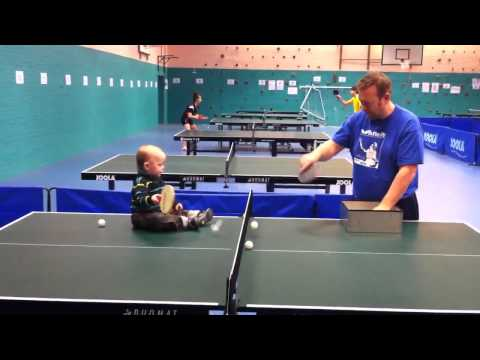

In [2]:
%autosave 0
from IPython.display import YouTubeVideo
YouTubeVideo("1n5uFGk2pnc")

# Getting Started

It is assumed that you followed the [local installation guide of the NRP](https://bitbucket.org/hbpneurorobotics/neurorobotics-platform).

All the configuration files and the python scripts specific to an experiment are located in the folder **Experiments/** (except the brain and the robot which are located in **Models/**). Let's make a copy of the tutorial:

```bash
cd $HBP/Experiments/
cp -r tutorial_baseball_exercise my_first_experiment
cd my_first_experiment
mv ExDTutorialBaseballExercise.exc ExDMyFirstExperiment.exc
```

The important files are:
* **tutorial_baseball.ipynb**: this notebook
* **ExDMyFirstExperiment.exc**: XML configuration of the experiment
* **tutorial_baseball.bibi**: XML configuration of the brain/body interaction
* **throw_ball.exd**: A state machine referenced in the **.exc**
* ***.py**: Transfer functions referenced in the **.bibi**

Let's edit the **ExDMyFirstExperiment.exc** to change the name of the experiment:
```bash
sed -i "s/<name>.*<\/name>/<name>My First Experiment<\/name>/g" ExDMyFirstExperiment.exc
```

In the following exercises, we will edit the transfer functions and state machine through the Neurorobotics Platform editors. If you want to persist your edits, make sure to save the text back in the respective files in the  **my_first_experiment/** folder.

# Exercise 1: Setting up the experiment interactively

Start the NRP with the following commands:
```shell
cle-nginx
cle-start
cle-frontend
```
and launch the experiment **My First Experiment** that you just created.

The experiment contains an iCub Robot in an empty world. Click the play button, nothing happens.
We will now implement the components one by one to have our iCub playing baseball controlled by a spiking neural network.

## Throwing balls - StateMachine

The first step is to have a ball throwing machine. Since this concerns purely the environment and not the robot, we implement this in a **state machine**.

Open the **NRP editors** (pen button in the toolbar), and select the **State Machine (SMACH)** tab.
Two **States** are defined: one to spawn new ball, the other to remove them when they are too low.

Complete the code where you find the comments
```py
#################################################
# Insert code here:
#################################################
```

Don't forget to click the **Apply** button and **start** the experiment if necessary.

## Moving the robot to a pre-swing pose - Neuron2Robot 

You should now have an experiment with balls that are being spawned and thrown in the direction of the iCub. We will first move the iCub to a proper swinging position. Since this concerns purely the robot, we implement this in a **transfer function (TF)**. 

Open the **NRP editors** again and select the **Transfer Functions** tab. Every function defined here are called at regular 20ms intervals.

Start with the function **simple_move_robot**. This is a **Neuron2Robot** TF but does not listen to any brain neuron - it simply send motor commands to the robot in open loop.
Move the arm of the robot so that its hand hits the thrown balls.

## Converting vision to brain activity - Robot2Neuron 

The robot has a brain of 20 sensor neurons and one motor neuron, connected all to all.
You can see the **Brain Editor** in the **Transfer Functions** tab of the **NRP editors**. You can also visualize the neurons and their activity with the **brain visualizer** in the toolbar.

We want the camera images sensed by the robot to activate the sensor neurons. For this purpose, we will use a **Robot2Neuron** transfer function. Go to the function **grab_image** and activate the sensor neurons with respect to the difference in green values.

You can see what the robot see with the **generic image viewer** and the brain activity of a neuronal population with the **spiketrain**. The population displayed is defined in the **NeuronMonitor** transfer function and is set to the sensors population initially.

## Converting brain activity to action - Neuron2Robot 

The input neurons should now spike with respect to the positive difference of green in images.
We now want to make the robot arm swing with respect to the motor neuron activation. Implement the **Neuron2Robot** transfer function, here named **swing**.



# Exercise 2: Offline analysis and optimization with virtual coach

In the first exercise, you interactively built your experiment so that it works with some hardcoded parameters.
In this exercise, we will run the experiment offline with the **Virtual Coach** to:
* Visualize some data
* Optimize some hardcoded parameters
You will see that the **Virtual Coach** has an API that replaces everything you did mannually in the first exercise: launch an experiment, start it, add a transfer function, set the brain,...

For this part of the notebook, you will need some extra libraries:
```
pip install --user pandas matplotlib
```

Let's import the **Virtual Coach**. Make sure you started your jupyter notebook with the command
```bash
cle-virtual-coach jupyter notebook
```

In [9]:
# disable global logging from the virtual coach
import logging
logging.disable(logging.INFO)
logging.getLogger('rospy').propagate = False
logging.getLogger('rosout').propagate = False

In [10]:
# log into the virtual coach, update with your credentials
try:
    from hbp_nrp_virtual_coach.virtual_coach import VirtualCoach
    vc = VirtualCoach(environment='local')
except ImportError as e:
    print(e)
    print("You have to start this notebook with the command:\
          cle-virtual-coach jupyter notebook")
    raise e

## First steps with the Virtual Coach

The virtual coach launch experiments return a well-documented simulation object with which you can interact:

In [43]:
sim = vc.launch_experiment('ExDMyFirstExperiment')

In [44]:
methods = [method for method in dir(sim) if not method.startswith('_')]
print('Available method on the simulation object:\n{}'.format('\n'.join(methods)))

Available method on the simulation object:
add_state_machine
add_transfer_function
delete_state_machine
delete_transfer_function
edit_brain
edit_populations
edit_state_machine
edit_transfer_function
get_brain
get_csv_data
get_populations
get_state
get_state_machine
get_transfer_function
launch
pause
print_csv_file_names
print_state_machines
print_transfer_functions
register_status_callback
reset
start
stop


In [45]:
sim.register_status_callback?

If you have the frontend running, you can see that there is a running instance of this experiment if you click on it.
You can stop the experiment either with the frontend or with the virtual coach:

In [46]:
sim.stop()

## Visualization and optimization

We provide a **Trial** class that eases the process of launching experiments with different parameters and record data from them.
Specifically, we will try to find the best synaptic weight between the input and the output populations.
The objective we try to maximize is the absolute **x** position of the ball (the ball is fired in the negative **x** direction, c.f. the StateMachine).

In [ ]:
# reusable Trial class definition
import time
import csv
import tempfile
import os

class Trial(object):
    '''
    Reusable class to launch a trial of an experiment for optimization.
    '''

    def __init__(self, vc, brain_template, experiment_id="ExDMyFirstExperiment", 
                 data_dir = None, automate = True,
                 tf_functions=[], brain_params={'syn_weight': 1.0}):

        # store runtime configuration
        if not data_dir:
            data_dir = tempfile.mkdtemp()
        self.data_dir = data_dir
        self._done = False
        self._automate = automate
        self._brain_template = brain_template
        self._experiment_id = experiment_id

        # launch the experiment and register for status messages
        self.sim = vc.launch_experiment(self._experiment_id)
        try:
            self.sim.register_status_callback(self._on_status)
        
            # add the additional transfer functions
            for tf_function in tf_functions:
                self.sim.add_transfer_function(tf_function)

            # set the brain
            self.sim.edit_brain(self._brain_template.format(**brain_params))
        except Exception as e:
            self.sim.stop()

    def run(self):
        '''
        Blocking call, run the experiment until it is terminated.
        '''

        # if this is not an interactive launch intended for a user, automatically start
        if self._automate:
            self.sim.start()

        # wait until the simulation terminates cleanly, blocking call
        while not self._done:
            time.sleep(1.0)
    
    def _save_csv_files(self):
        '''
        Save all the csv files recorded by an experiment
        '''
        
        self.csv_filenames = ['ball_position.csv', 'joint_positions.csv']
        for csv_name in self.csv_filenames:
            with open(os.path.join(self.data_dir, csv_name), 'wb') as f:
                cf = csv.writer(f)
                cf.writerows(self.sim.get_csv_data(csv_name))

    def _on_status(self, msg):
        '''
        Receive and process simulation status events, registered as a callback in constructor.
        '''
        print("Current simulation time: {}".format(msg['simulationTime']))
        # simulation has been terminated
        if msg['state'] == 'stopped':
            self._done = True
            return

        # simulation timeline events, only stop when non interactive
        if self._automate and msg['simulationTime'] == 5.0:
            self.sim.pause()

            # write all position data to disk if a path was given
            if self.data_dir:
                self._save_csv_files()

            self.sim.stop()
            print("Trial terminated")

### The brain

The **Trial** class expects a brain file parametrized with **{syn_weight}**:

In [47]:
brain_template = '''
# -*- coding: utf-8 -*-
"""
Tutorial brain for the baseball experiment
"""

# pragma: no cover
__author__ = 'Jacques Kaiser'

from hbp_nrp_cle.brainsim import simulator as sim
import numpy as np

n_sensors = 20
n_motors = 1

sensors = sim.Population(n_sensors, cellclass=sim.IF_curr_exp())
motors = sim.Population(n_motors, cellclass=sim.IF_curr_exp())
sim.Projection(sensors, motors, sim.AllToAllConnector(),
               sim.StaticSynapse(weight={syn_weight}))
'''

### The (additional) transfer functions

It also expects some additional transfer functions that are added to the simulation.
Here, we define two transfer functions for recording data in CSV files thanks to the **MapCSVRecorder**.
The first TF records the ball position, the second TF records the joints of the robot.
You could also add those transfer functions as python files in the **Experiments/my_first_experiment** folder and reference them in the **.bibi**, the results would be identical.

In [52]:
record_ball_tf = \
'''
# Imported Python Transfer Function
import numpy as np
import sensor_msgs.msg

@nrp.MapCSVRecorder("ball_recorder", filename="ball_position.csv",
                    headers=["Time", "px", "py", "pz"])
@nrp.Robot2Neuron()
def record_ball_csv(t, ball_recorder):
    from rospy import ServiceProxy
    from gazebo_msgs.srv import GetModelState

    model_name = 'ball'
    state_proxy = ServiceProxy('/gazebo/get_model_state',
                                    GetModelState, persistent=False)
    ball_state = state_proxy(model_name, "world")

    if ball_state.success:
        current_position = ball_state.pose.position
        ball_recorder.record_entry(t,
                                   current_position.x, 
                                   current_position.y, 
                                   current_position.z)
'''

In [53]:
record_joints_tf = \
'''
# Imported Python Transfer Function
import numpy as np
import sensor_msgs.msg

@nrp.MapRobotSubscriber("joint_states", Topic('/robot/joints', sensor_msgs.msg.JointState))
@nrp.MapCSVRecorder("joint_recorder", filename="joint_positions.csv", headers=["Time", "Name", "Position"])
@nrp.Robot2Neuron()
def record_joint_csv(t, joint_states, joint_recorder):
    if not isinstance(joint_states.value, type(None)):
        for i in range(0, len(joint_states.value.name)):
            joint_recorder.record_entry(t, \
                                        joint_states.value.name[i], \
                                        joint_states.value.position[i] \
                                        )
'''

## Running the Trial with the default synaptic weight

In [54]:
trial = Trial(vc, brain_template, experiment_id='ExDMyFirstExperiment', 
              tf_functions=[record_ball_tf, record_joints_tf])
trial.run()

Current simulation time: 0
Current simulation time: 0
Current simulation time: 1
Current simulation time: 2
Current simulation time: 2
Current simulation time: 3
Current simulation time: 3
Current simulation time: 4
Current simulation time: 4
Current simulation time: 5
Trial terminated
Current simulation time: 6


If everything went fine, the csv data got saved to a **tempdir** in your **/tmp/**:

In [55]:
all_csv_files = [ os.path.join(trial.data_dir, csv_name) for csv_name in trial.csv_filenames ]
print("Recorded the following csv files:\n{}".format(all_csv_files))

Recorded the following csv files:
['/tmp/tmpeZWijR/ball_position.csv', '/tmp/tmpeZWijR/joint_positions.csv']


## Plotting the CSV data

Let's use [pandas](http://pandas.pydata.org/) to read the csv files, create dataframes and plot them.
You will need to install pandas:

```bash
pip install pandas
```

Let's read the csv files with pandas:

In [71]:
import pandas
ball_csv, joint_csv = [ pandas.read_csv(csv_file) for csv_file in all_csv_files ]
ball_csv

,Time,px,py,pz
0,0.00,3.000000,-0.280000,0.697942
1,0.02,2.981579,-0.280000,0.697490
2,0.04,2.928070,-0.280000,0.703645
3,0.06,2.839474,-0.280000,0.716406
4,0.08,2.715789,-0.280000,0.735773
5,0.10,2.557018,-0.280000,0.761747
6,0.12,2.381579,-0.280000,0.788800
7,0.14,2.206140,-0.280000,0.811934
8,0.16,2.030702,-0.280000,0.831147
9,0.18,1.855263,-0.280000,0.846441


In [73]:
def prepare_r_shoulder_yaw_csv(shoulder_csv):
    shoulder_csv = shoulder_csv[shoulder_csv['Name'] == 'r_shoulder_yaw'][['Time', 'Position']]
    return shoulder_csv

def merge_csv_files(ball_csv, shoulder_csv):
    ball_df = ball_csv[['Time', 'px']]
    shoulder_df = prepare_r_shoulder_yaw_csv(shoulder_csv)
    merged_df = pandas.merge(ball_df, shoulder_df).set_index(['Time'])
    return merged_df

def make_merged_df():
    merged_df = merge_csv_files(ball_csv, joint_csv)
    return merged_df

In [74]:
import matplotlib.pyplot as plt

def make_displacement_plot(data_frame, trial=0):
    #ax, = plt.plot(data_frame.px, data_frame.Position)
    ax = data_frame.plot(title='Hand/Ball Position Displacement, Trial={}'.format(trial), figsize=(8., 8.))
    ax.legend(('Ball X-Coordinate', 'R_shoulder Angle'))

    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Position [m]')
    return ax

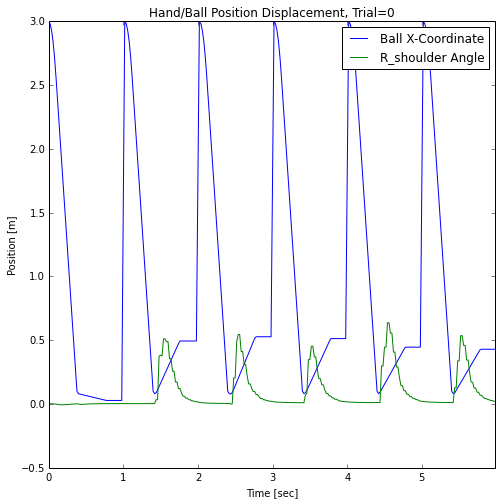

In [65]:
%matplotlib inline

merged_df = make_merged_df()
ax = make_displacement_plot(merged_df)

You can see that ball position is initially high when the ball is created, it then decreases until it hits the robot, and only after the robot starts to move its shoulder.

## Optimizing the synaptic weight

We define the objective function as being the accumulated **x** position. Let's run many trials with different synaptic weights and see the evolution of accumulated **x** position. For example, with this current trial of synaptic weight 1.0, the accumulated **x** is:

In [78]:
ball_csv.px.sum()

257.98952236623904

In [91]:
import numpy as np
trial_weights = np.linspace(0., 1.5, 10)
trial_ball_csv = []
for w in trial_weights:
    print('Simulation for weight {}'.format(w))
    trial = Trial(vc, brain_template, experiment_id='ExDMyFirstExperiment', 
                  tf_functions=[record_ball_tf, record_joints_tf], brain_params={'syn_weight': w} )
    trial.run()
    trial_ball_csv.append(os.path.join(trial.data_dir, trial.csv_filenames[0]))
    time.sleep(5.)

Simulation for weight 0.0
Current simulation time: 0
Current simulation time: 0
Current simulation time: 1
Current simulation time: 1
Current simulation time: 2
Current simulation time: 3
Current simulation time: 3
Current simulation time: 4
Current simulation time: 4
Current simulation time: 5
Trial terminated
Current simulation time: 5
ERROR: [2017-08-01 10:57:54,622 - bbp_client.oidc.client] Failed to retrieve data: {"data": null, "message": "Invalid transition (stopped->paused)", "type": "Transition error"}
ERROR: [2017-08-01 10:57:54,622 - bbp_client.oidc.client] Failed to retrieve data: {"data": null, "message": "Invalid transition (stopped->paused)", "type": "Transition error"}
Current simulation time: 5


[ERROR] [WallTime: 1501577874.624438] [5.821000] bad callback: <bound method Simulation.__on_status of <hbp_nrp_virtual_coach.simulation.Simulation object at 0x7fb721eb6f50>>
Traceback (most recent call last):
  File "/opt/ros/indigo/lib/python2.7/dist-packages/rospy/topics.py", line 720, in _invoke_callback
    cb(msg)
  File "/home/jkaiser/Workspace/HBP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 275, in __on_status
    callback(status)
  File "<ipython-input-2-bed884c6b469>", line 74, in _on_status
    self.sim.pause()
  File "/home/jkaiser/Workspace/HBP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 172, in pause
    self.__set_state('paused')
  File "/home/jkaiser/Workspace/HBP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 231, in __set_state
    res, _ = self.__oidc_client.request(url, method='PUT', body=json.dumps({'state': state}))
  File "/home/jkaiser/.opt/platform_venv/lib/python

Simulation for weight 0.111111111111
Current simulation time: 0
Current simulation time: 0
Current simulation time: 1
Current simulation time: 2
Current simulation time: 2
Current simulation time: 3
Current simulation time: 3
Current simulation time: 4
Current simulation time: 4
Current simulation time: 5
Trial terminated
Current simulation time: 6
Simulation for weight 0.222222222222
Current simulation time: 0
Current simulation time: 0
Current simulation time: 1
Current simulation time: 2
Current simulation time: 2
Current simulation time: 3
Current simulation time: 3
Current simulation time: 4
Current simulation time: 4
Current simulation time: 5
Trial terminated
Current simulation time: 6
Simulation for weight 0.333333333333
Current simulation time: 0
Current simulation time: 0
Current simulation time: 1
Current simulation time: 1
Current simulation time: 2
Current simulation time: 2
Current simulation time: 3
Current simulation time: 3
Current simulation time: 4
Current simulation

[ERROR] [WallTime: 1501578071.860252] [5.941000] bad callback: <bound method Simulation.__on_status of <hbp_nrp_virtual_coach.simulation.Simulation object at 0x7fb6dc4d3b10>>
Traceback (most recent call last):
  File "/opt/ros/indigo/lib/python2.7/dist-packages/rospy/topics.py", line 720, in _invoke_callback
    cb(msg)
  File "/home/jkaiser/Workspace/HBP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 275, in __on_status
    callback(status)
  File "<ipython-input-2-bed884c6b469>", line 74, in _on_status
    self.sim.pause()
  File "/home/jkaiser/Workspace/HBP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 172, in pause
    self.__set_state('paused')
  File "/home/jkaiser/Workspace/HBP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 231, in __set_state
    res, _ = self.__oidc_client.request(url, method='PUT', body=json.dumps({'state': state}))
  File "/home/jkaiser/.opt/platform_venv/lib/python

Simulation for weight 0.888888888889
Current simulation time: 0
Current simulation time: 0
Current simulation time: 1
Current simulation time: 2
Current simulation time: 2
Current simulation time: 3
Current simulation time: 3
Current simulation time: 4
Current simulation time: 4
Current simulation time: 5
Trial terminated
Current simulation time: 5
Simulation for weight 1.0
Current simulation time: 0
Current simulation time: 0
Current simulation time: 1
Current simulation time: 2
Current simulation time: 2
Current simulation time: 3
Current simulation time: 3
Current simulation time: 4
Current simulation time: 4
Current simulation time: 5
Trial terminated
Current simulation time: 6


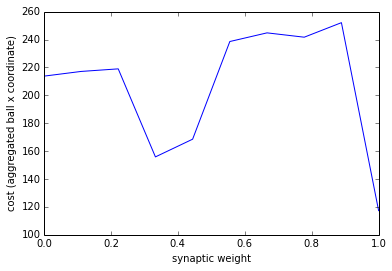

In [92]:
import matplotlib.pyplot as plt

def plot_cost(trial_weights, trial_ball_csv):
    trial_costs = []
    # compute the cost of each trial through the CSV files
    for ball_csv in trial_ball_csv:
        ball_position = pandas.read_csv(ball_csv)
        trial_costs.append(ball_position.px.sum())        
    # plot it with respect to the weight
    plt.plot(trial_weights, trial_costs)
    plt.xlabel('synaptic weight')
    plt.ylabel('cost (aggregated ball x coordinate)')
    plt.show()

plot_cost(trial_weights, trial_ball_csv)